In [1]:
import numpy as np
import pandas as pd
import scipy
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
import scipy.optimize
import time
plt.rcParams["figure.figsize"] = (3,3)

read a data file, create Pandas (.pd) data table

In [2]:
#file1 = "FourIonsTelegraf_100s_W0028_H11-200211-013412-1_cent.csv"
file1 = "FourIons_100s_W0028_H11-200211-012037-1_cent.csv"
data=np.loadtxt(file1, dtype= float, delimiter=",", usecols = (0,1,2))
data_table = pd.read_csv(file1)


Rename columns, drop unwanted columns, correct time values

In [3]:
data_table = pd.read_csv(file1)                                                                       #Create Pandas Table
data_table.rename(columns = {"#Col":"y", "#Row":"x", "#ToA":"time"}, inplace=True)                    #Rename Columns
data_table.drop(columns = {'#ToT[arb]', '#ToTtotal[arb]', '#Centroid', 'Unnamed: 6'}, inplace=True)   #Remove unwanted columns
real_time = (data_table['time'] / (4096.*25.))                                                        #Time Conversion
data_table['time'] = real_time                                                                        #Insert new times

Create spatial contraints to determine ion locations

In [4]:
dark_state = (
        data_table
        .query("time > 1.52e8")
        .reset_index(drop=True)
)
light_state = (
        data_table
        .query("time < 1.52e8")
        .reset_index(drop=True)
)

In [5]:
ion_1 = (
    data_table
    .query("66 <= x <= 75 and 94 <= y <= 104") #Right side is 1 less than bin edge will be. 
    .reset_index(drop=True)      #Not sure why this code takes so long
)


In [6]:
ion_2 = (
    data_table
    .query("76 <= x <= 85 and 94 <= y <= 104") #Right side is 1 less than bin edge will be. 
    .reset_index(drop=True)      #Not sure why this code takes so long
)


In [7]:
ion_3 = (
    data_table
    .query("85 <= x <= 94 and 94 <= y <= 105") #Right side is 1 less than bin edge will be. 
    .reset_index(drop=True)      #Not sure why this code takes so long
)


In [8]:
ion_4 = (
    data_table
    .query("94 <= x <= 101 and 94 <= y <= 105") #Right side is 1 less than bin edge will be. 
    .reset_index(drop=True)      #Not sure why this code takes so long
)

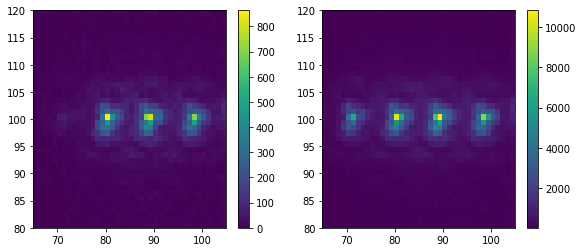

In [9]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(9.5, 4))

h = ax0.hist2d(dark_state['x'], dark_state['y'], bins = [40,40], range = [(65, 105), (80, 120)])
fig.colorbar(h[3], ax = ax0)

h = ax1.hist2d(light_state['x'], light_state['y'], bins = [40,40], range = [(65, 105), (80, 120)])
fig.colorbar(h[3], ax = ax1)

#h = ax1.hist2d(dark_state['x'], dark_state['y'], bins = [40,40], range = [(65, 105), (80, 120)], norm=mpl.colors.LogNorm())
#fig.colorbar(h[3], ax = ax1)
#fig.tight_layout()
#plt.show()

This next graph displays the constraints on just one ion

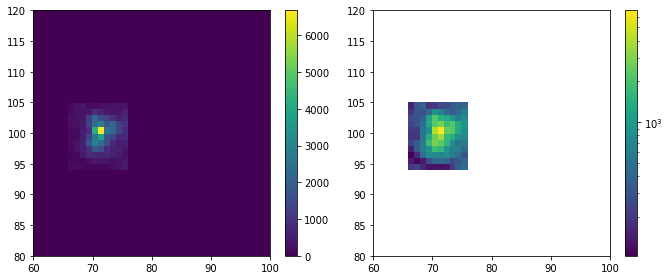

In [10]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(9.5, 4))

h = ax0.hist2d(ion_1['x'], ion_1['y'], bins = 40, range = [(60, 100), (80, 120)])
fig.colorbar(h[3], ax = ax0)

h = ax1.hist2d(ion_1['x'], ion_1['y'], bins = 40, range = [(60, 100), (80, 120)], norm=mpl.colors.LogNorm())
fig.colorbar(h[3], ax = ax1)
fig.tight_layout()
plt.show()

The next 5 cells were me trying to figure out how to fit the data to a Gaussian. I took data from the histograms and turned them into data for a bar chart which can be plotted and optimized. 

Text(0.5, 1.0, 'Ion 4 Y')

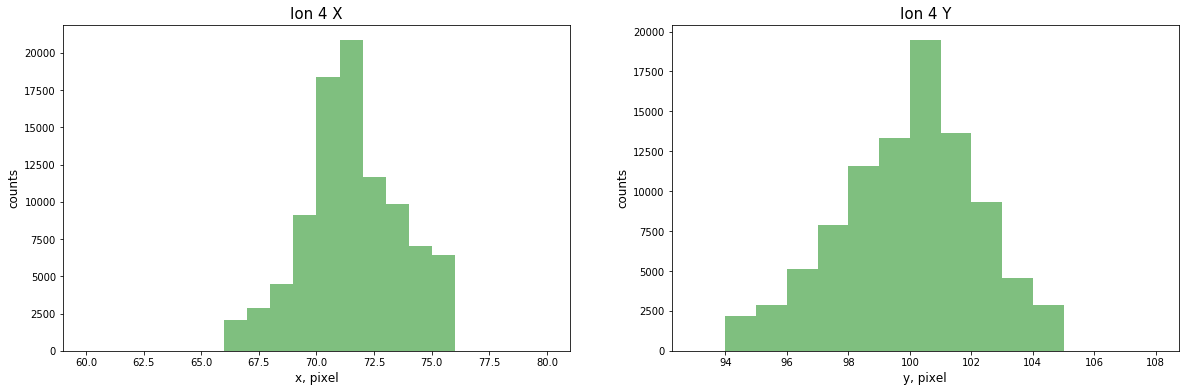

In [11]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 6))

ax0.hist(ion_1['x'], bins = 20, range = (60, 80), color = 'g', alpha=0.5, histtype = 'stepfilled')
ax0.set_xlabel('x, pixel',fontsize = 12)
ax0.set_ylabel('counts',fontsize = 12)
#plt.xlim(50, 150)
ax0.set_title("Ion 4 X", fontsize = 15)

ax1.hist(ion_1['y'], bins = 15, range = (93, 108), color = 'g', alpha=0.5, histtype = 'stepfilled')
ax1.set_xlabel('y, pixel',fontsize = 12)
ax1.set_ylabel('counts',fontsize = 12)
#plt.xlim(86, 116)
ax1.set_title("Ion 4 Y", fontsize = 15)

Text(0.5, 1.0, 'Ion 4 Y')

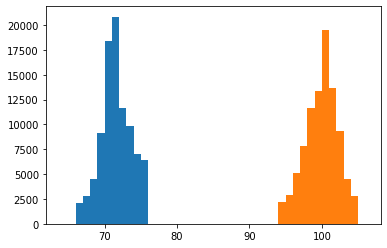

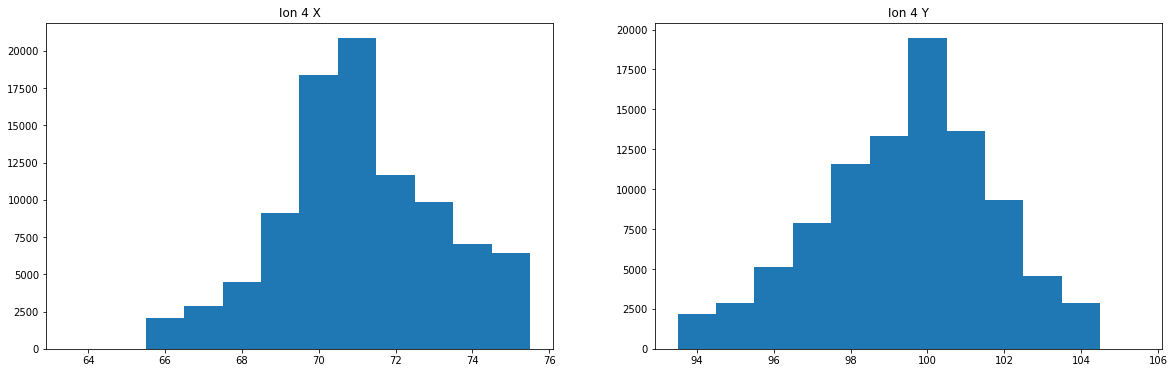

In [12]:
xcounts, xbins, xbars = plt.hist(ion_1['x'], 12, (64,76))
xdata = pd.DataFrame(
    {'x': xbins[0:12],
    'count': xcounts})

ycounts, ybins, ybars = plt.hist(ion_1['y'], 12, (94,106))
ydata = pd.DataFrame(
    {'y': ybins[0:12],
    'count': ycounts})

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 6))
ax0.bar(xdata['x'], xdata['count'], width=1)
ax1.bar(ydata['y'], ydata['count'], width=1)
ax0.set_title("Ion 4 X")
ax1.set_title("Ion 4 Y")

In [13]:
#Fitting with Gaussian

xguess_mean = 71
xguess_sigma = 1
xguess_amp = 20000
xguess_c = 2500

xguess  = np.array([xguess_mean,xguess_sigma,xguess_amp,xguess_c])

def gaussian(x, xm, sigma, A, c): return np.absolute(A)*np.exp(-np.power((x-xm)/sigma,2)/2) + c

xpopt, xpcov = scipy.optimize.curve_fit(gaussian, xdata['x'], xdata['count'], p0=xguess, maxfev = 50000)

print ('xmean =', xpopt[0], 'xsigma =', xpopt[1], 'xampl = ', xpopt[2], 'xc = ', xpopt[3])

xfit = np.linspace(60, 80, 500)
xfitc = gaussian(xfit, xpopt[0], xpopt[1], xpopt[2], xpopt[3])


xmean = 70.89420977203136 xsigma = 1.6550095318282285 xampl =  17141.453032982263 xc =  1816.2338746206715


In [14]:
yguess_mean = 100
yguess_sigma = 1
yguess_amp = 35000
yguess_c = 5000

yguess  = np.array([yguess_mean,yguess_sigma,yguess_amp,yguess_c])

ypopt, ypcov = scipy.optimize.curve_fit(gaussian, ydata['y'], ydata['count'], p0=yguess, maxfev = 50000)

print ('ymean =', ypopt[0], 'ysigma =', ypopt[1], 'yampl = ', ypopt[2], 'yc = ', ypopt[3])

yfit = np.linspace(80, 110, 500)
yfitc = gaussian(yfit, ypopt[0], ypopt[1], ypopt[2], ypopt[3])



ymean = 99.73080214766547 ysigma = 1.9668931079348888 yampl =  15580.644560538503 yc =  1340.8296280033978


Text(0.5, 1.0, 'Ion Y Distribution')

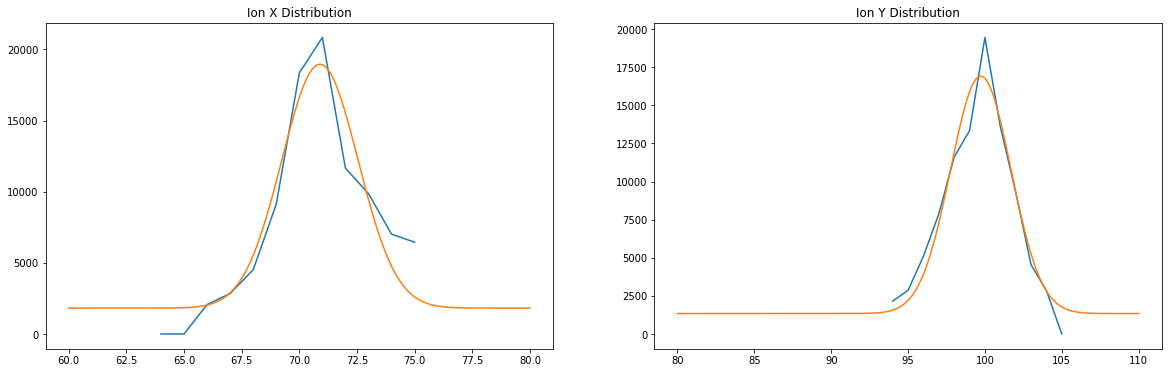

In [15]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(20, 6))

ax0.plot(xdata['x'], xdata['count'])
ax0.plot(xfit, xfitc)
ax0.set_title("Ion X Distribution")

ax1.plot(ydata['y'], ydata['count'])
ax1.plot(yfit, yfitc)
ax1.set_title("Ion Y Distribution")

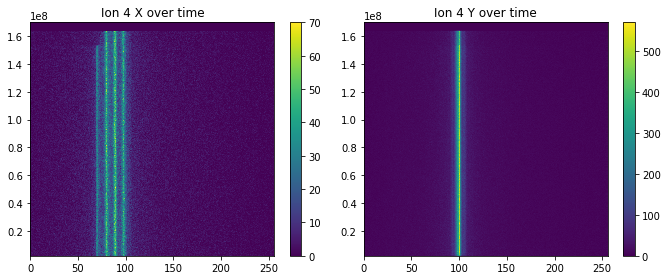

In [16]:
fig, (ax01, ax11) = plt.subplots(ncols=2, figsize=(9.5, 4))

h = ax01.hist2d(data_table['x'], data_table['time'], bins = [256, 1000], range = [(0, 256), (2e6, 1.7e8)])
fig.colorbar(h[3], ax = ax01)
ax01.set_title("Ion 4 X over time")

h = ax11.hist2d(data_table['y'], data_table['time'], bins = 256, range = [(0, 256), (2e6, 1.7e8)])
fig.colorbar(h[3], ax = ax11)
ax11.set_title("Ion 4 Y over time")
fig.tight_layout()
plt.show()

A lot of repedetive code, possibly could get optimized to run faster but it works for now. Created arrays out of the ion data sets for x and y. Arrays work best for the operations later. 

In [17]:
x_4 = ion_4['x']
y_4 = ion_4['y']
x_3 = ion_3['x']
y_3 = ion_3['y']
x_2 = ion_2['x']
y_2 = ion_2['y']
x_1 = ion_1['x']
y_1 = ion_1['y']
t_4 = ion_4['time']
t_3 = ion_3['time']
t_2 = ion_2['time']
t_1 = ion_1['time']


m = 100;
dtbins_4x = []; dtbins_4y = []
dtbins_3x = []; dtbins_3y = []
dtbins_2x = []; dtbins_2y = []
dtbins_1x = []; dtbins_1y = []

Split total time into m time chunks. Creates arrays for x and y in each of the time separations. 

In [19]:
 #split array dtc1 into m bins of 'time' (array tc11)

Tmin = min(t_4)
Tmax = max(t_4)

print ('Tmin =', Tmin, ' Tmax = ', Tmax, 'length = ', len(t_4))

Tbin = (Tmax - Tmin)/m
for i in range(0,m):
    start = Tmin + i*Tbin; stop = start + Tbin
    dtbins_4x.append([])
    dtbins_4y.append([])
    print(i, start, stop)
    for j in range(len(x_4)):
        if(start < t_4[j] < stop): 
            dtbins_4x[i].append(x_4[j])
            dtbins_4y[i].append(y_4[j])

Tmin = 2168170.615  Tmax =  164188633.015 length =  134338
0 2168170.615 3788375.239
1 3788375.239 5408579.863
2 5408579.863 7028784.487
3 7028784.487 8648989.111
4 8648989.111 10269193.735
5 10269193.735 11889398.359
6 11889398.359 13509602.983
7 13509602.983 15129807.606999999
8 15129807.606999999 16750012.230999999
9 16750012.230999999 18370216.854999997
10 18370216.854999997 19990421.478999995
11 19990421.479000002 21610626.103
12 21610626.103 23230830.726999998
13 23230830.726999998 24851035.350999996
14 24851035.350999996 26471239.974999994
15 26471239.975 28091444.599
16 28091444.599 29711649.222999997
17 29711649.222999997 31331853.846999995
18 31331853.846999995 32952058.470999993
19 32952058.471 34572263.095
20 34572263.095 36192467.719
21 36192467.719 37812672.342999995
22 37812672.343 39432876.967
23 39432876.967 41053081.591
24 41053081.591 42673286.214999996
25 42673286.214999996 44293490.838999994
26 44293490.838999994 45913695.46299999
27 45913695.463 47533900.087
28 47

Fit each separated array for x and y to its own Gaussian, extract mean, sigma, amplitude, and constant into their own arrays for the ion. 

In [20]:
mean_4x = []; mean_4y = []
sigma_4x = []; sigma_4y = []
amp_4x = []; amp_4y = []
c_4x = []; c_4y = []

xguess_mean_4 = 97.5
xguess_sigma_4 = 1
xguess_amp_4 = 30000/m
xguess_c_4 = 10000/m
xguess_4  = np.array([xguess_mean_4,xguess_sigma_4,xguess_amp_4,xguess_c_4])

yguess_mean_4 = 101
yguess_sigma_4 = 1
yguess_amp_4 = 25000/m
yguess_c_4 = 5000/m
yguess_4  = np.array([yguess_mean_4,yguess_sigma_4,yguess_amp_4,yguess_c_4])

for i in range(0, m):
    hist_4x, bins_4x = np.histogram(dtbins_4x[i], 8, (94,102)) #, density=True),
    bin_centres_4x = (bins_4x[:-1] + bins_4x[1:])/2
    popt_4x, pcov_4x = scipy.optimize.curve_fit(gaussian, bin_centres_4x, hist_4x, p0=xguess_4, maxfev = 50000)
    mean_4x.append(popt_4x[0]); sigma_4x.append(popt_4x[1]); amp_4x.append(popt_4x[2]); c_4x.append(popt_4x[3])
    hist_fit_4x = gaussian(bin_centres_4x, *popt_4x)
    
    hist_4y, bins_4y = np.histogram(dtbins_4y[i], 11, (95,106)) #, density=True) 
    bin_centres_4y = (bins_4y[:-1] + bins_4y[1:])/2
    popt_4y, pcov_4y = scipy.optimize.curve_fit(gaussian, bin_centres_4y, hist_4y, p0=yguess_4, maxfev = 50000)
    mean_4y.append(popt_4y[0]); sigma_4y.append(popt_4y[1]); amp_4y.append(popt_4y[2]); c_4x.append(popt_4y[3])
    hist_fit_4y = gaussian(bin_centres_4y, *popt_4y)
    
#    plt.figure(figsize=(8, 4))
#    plt.plot(bin_centres_4x, hist_4x, 'ro')
#    plt.plot(bin_centres_4x, hist_fit_4x)
#    plt.plot(bin_centres_4y, hist_4y, 'go')
#    plt.plot(bin_centres_4y, hist_fit_4y)
#    plt.show()

Plot all of the arrays. 

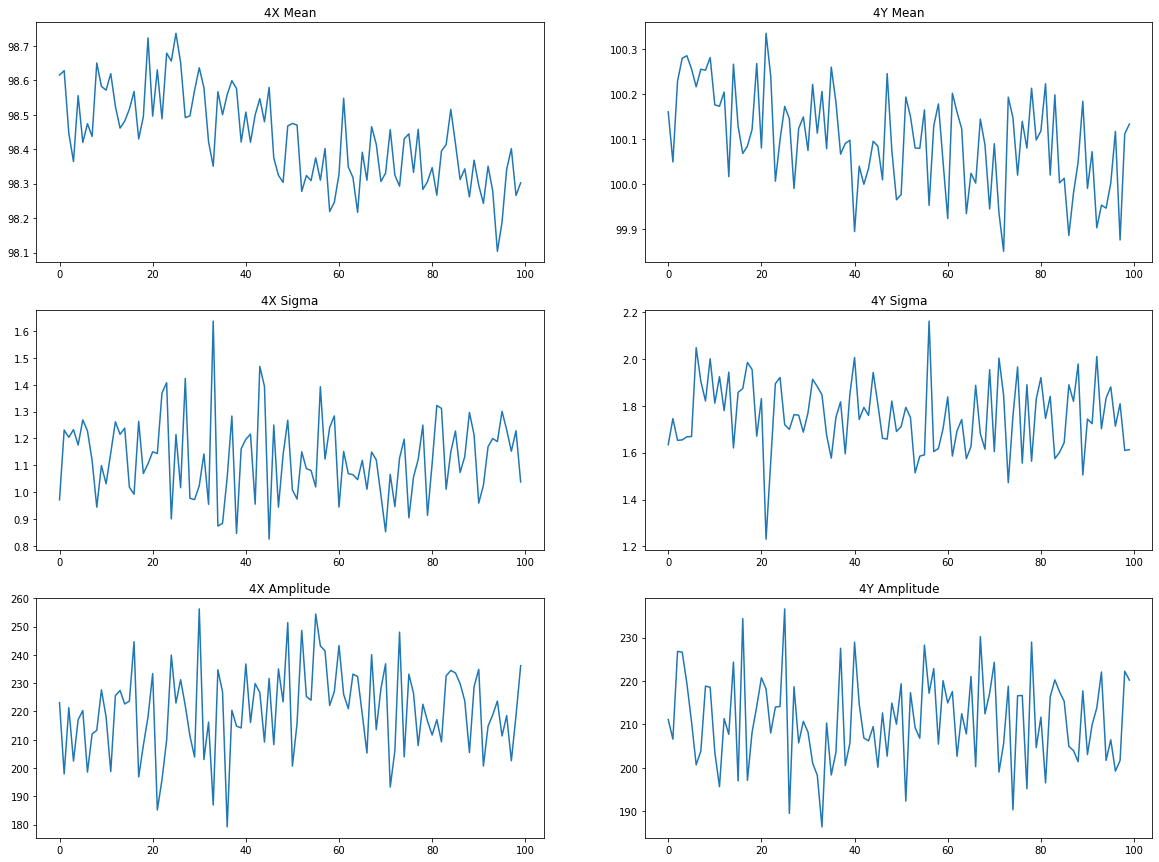

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))

ax[0,0].plot(mean_4x); ax[0,0].set_title("4X Mean");
ax[0,1].plot(mean_4y); ax[0,1].set_title("4Y Mean")
ax[1,0].plot(sigma_4x); ax[1,0].set_title("4X Sigma"); #ax[1,0].set_ylim(-5,7)
ax[1,1].plot(sigma_4y);ax[1,1].set_title("4Y Sigma"); #ax[1,1].set_ylim(-2,5)
ax[2,0].plot(amp_4x); ax[2,0].set_title("4X Amplitude"); #ax[2,0].set_ylim(top=300)
ax[2,1].plot(amp_4y); ax[2,1].set_title("4Y Amplitude"); #ax[2,1].set_ylim(top=260)

Repeat it all over again for the rest of the ions. 

In [22]:
#split array dtc1 into m bins of 'time' (array tc11)

Tmin = min(t_3)
Tmax = max(t_3)

print ('Tmin =', Tmin, ' Tmax = ', Tmax, 'length = ', len(t_3))

Tbin = (Tmax - Tmin)/m
for i in range(0,m):
    start = Tmin + i*Tbin; stop = start + Tbin
    dtbins_3x.append([])
    dtbins_3y.append([])
    print(i, start, stop)
    for j in range(len(x_3)):
        if(start < t_3[j] < stop): 
            dtbins_3x[i].append(x_3[j])
            dtbins_3y[i].append(y_3[j])

Tmin = 2167369.26  Tmax =  164189223.1375 length =  180356
0 2167369.26 3787587.7987749996
1 3787587.7987749996 5407806.337549999
2 5407806.337549999 7028024.876324999
3 7028024.876325 8648243.4151
4 8648243.4151 10268461.953875002
5 10268461.953875 11888680.49265
6 11888680.49265 13508899.031425001
7 13508899.031425 15129117.5702
8 15129117.5702 16749336.108975
9 16749336.108975 18369554.64775
10 18369554.647749998 19989773.186525
11 19989773.186525002 21609991.725300003
12 21609991.7253 23230210.264075
13 23230210.264075004 24850428.802850004
14 24850428.80285 26470647.341625
15 26470647.341624998 28090865.8804
16 28090865.880400002 29711084.419175003
17 29711084.419175 31331302.95795
18 31331302.957950003 32951521.496725004
19 32951521.496725 34571740.0355
20 34571740.0355 36191958.574274994
21 36191958.574275 37812177.11305
22 37812177.11305 39432395.651824996
23 39432395.651824996 41052614.19059999
24 41052614.1906 42672832.729375
25 42672832.729375 44293051.268149994
26 44293051.

In [23]:
mean_3x = []; mean_3y = []
sigma_3x = []; sigma_3y = []
amp_3x = []; amp_3y = []
c_3x = []; c_3y = []

xguess_mean_3 = 90
xguess_sigma_3 = 1
xguess_amp_3 = 30000/m
xguess_c_3 = 10000/m
xguess_3  = np.array([xguess_mean_3,xguess_sigma_3,xguess_amp_3,xguess_c_3])

yguess_mean_3 = 99
yguess_sigma_3 = 1
yguess_amp_3 = 35000/m
yguess_c_3 = 5000/m
yguess_3  = np.array([yguess_mean_3,yguess_sigma_3,yguess_amp_3,yguess_c_3])

for i in range(0, m):
    hist_3x, bins_3x = np.histogram(dtbins_3x[i], 9, (85,94)) #, density=True),
    bin_centres_3x = (bins_3x[:-1] + bins_3x[1:])/2
    popt_3x, pcov_3x = scipy.optimize.curve_fit(gaussian, bin_centres_3x, hist_3x, p0=xguess_3, maxfev = 50000)
    mean_3x.append(popt_3x[0]); sigma_3x.append(popt_3x[1]); amp_3x.append(popt_3x[2]); c_3x.append(popt_3x[3])
    hist_fit_3x = gaussian(bin_centres_3x, *popt_3x)
    
    hist_3y, bins_3y = np.histogram(dtbins_3y[i], 11, (95,106)) #, density=True) 
    bin_centres_3y = (bins_3y[:-1] + bins_3y[1:])/2
    popt_3y, pcov_3y = scipy.optimize.curve_fit(gaussian, bin_centres_3y, hist_3y, p0=yguess_3, maxfev = 50000)
    mean_3y.append(popt_3y[0]); sigma_3y.append(popt_3y[1]); amp_3y.append(popt_3y[2]); c_3x.append(popt_3y[3])
    hist_fit_3y = gaussian(bin_centres_3y, *popt_3y)
    
#    plt.figure(figsize=(8, 4))
#    plt.plot(bin_centres_4x, hist_4x, 'ro')
#    plt.plot(bin_centres_4x, hist_fit_4x)
#    plt.plot(bin_centres_4y, hist_4y, 'go')
#    plt.plot(bin_centres_4y, hist_fit_4y)
#    plt.show()

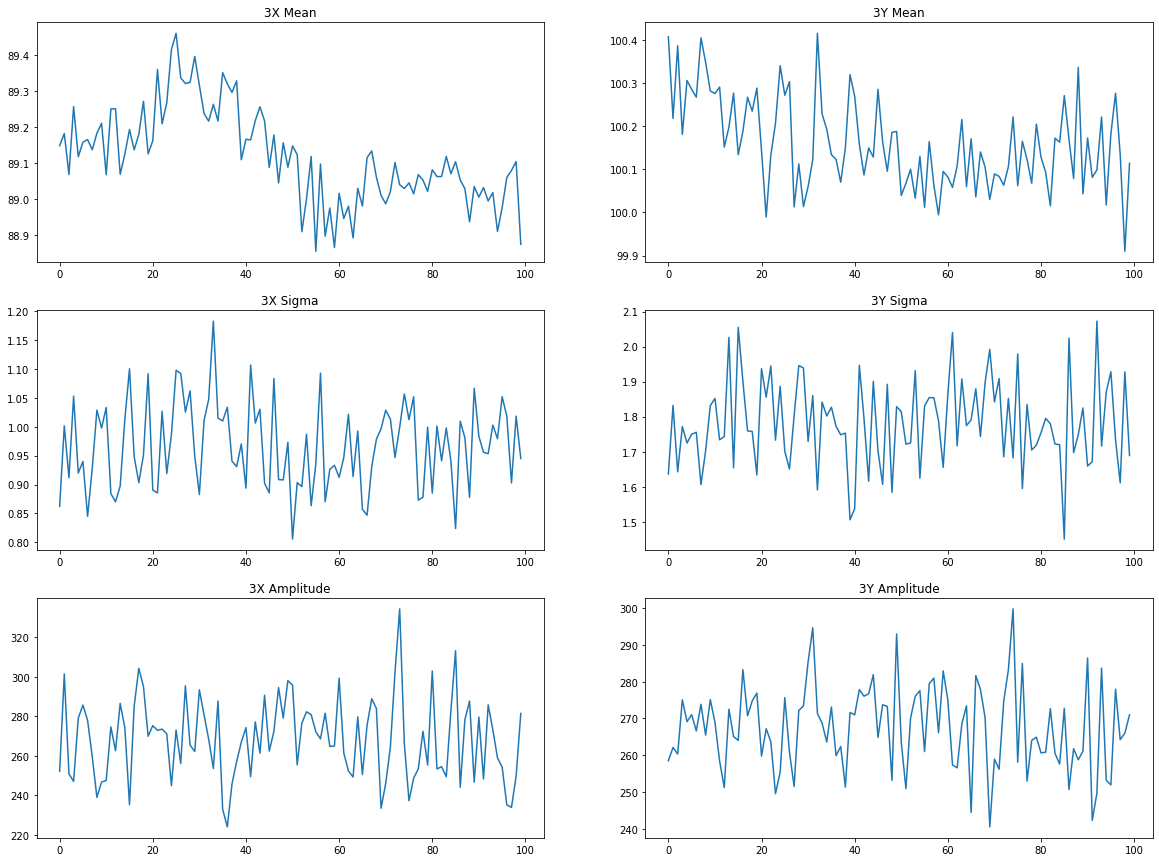

In [24]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))

ax[0,0].plot(mean_3x); ax[0,0].set_title("3X Mean"); 
ax[0,1].plot(mean_3y); ax[0,1].set_title("3Y Mean")
ax[1,0].plot(sigma_3x); ax[1,0].set_title("3X Sigma"); #ax[1,0].set_ylim(-2,5)
ax[1,1].plot(sigma_3y);ax[1,1].set_title("3Y Sigma"); #ax[1,1].set_ylim(-1,6)
ax[2,0].plot(amp_3x); ax[2,0].set_title("3X Amplitude"); #ax[2,0].set_ylim(0,400)
ax[2,1].plot(amp_3y); ax[2,1].set_title("3Y Amplitude"); #ax[2,1].set_ylim(0,400)

In [25]:
#split array dtc1 into m bins of 'time' (array tc11)

Tmin = min(t_2)
Tmax = max(t_2)

print ('Tmin =', Tmin, ' Tmax = ', Tmax, 'length = ', len(t_2))

Tbin = (Tmax - Tmin)/m
for i in range(0,m):
    start = Tmin + i*Tbin; stop = start + Tbin
    dtbins_2x.append([])
    dtbins_2y.append([])
    print(i, start, stop)
    for j in range(len(x_2)):
        if(start < t_2[j] < stop): 
            dtbins_2x[i].append(x_2[j])
            dtbins_2y[i].append(y_2[j])

Tmin = 2167239.045  Tmax =  164188646.9725 length =  161216
0 2167239.045 3787453.124275
1 3787453.124275 5407667.20355
2 5407667.20355 7027881.282825
3 7027881.282825001 8648095.362100001
4 8648095.362100001 10268309.441375002
5 10268309.441375 11888523.520650001
6 11888523.520650001 13508737.599925002
7 13508737.599925 15128951.679200001
8 15128951.679200001 16749165.758475002
9 16749165.758475002 18369379.837750003
10 18369379.837750003 19989593.917025004
11 19989593.917025 21609807.9963
12 21609807.996300004 23230022.075575005
13 23230022.075575 24850236.154850002
14 24850236.15485 26470450.234125
15 26470450.234125003 28090664.313400004
16 28090664.3134 29710878.392675
17 29710878.392675005 31331092.471950006
18 31331092.471950002 32951306.551225003
19 32951306.551225 34571520.630499996
20 34571520.6305 36191734.709775
21 36191734.70977501 37811948.789050005
22 37811948.789050005 39432162.868325
23 39432162.868325 41052376.9476
24 41052376.94760001 42672591.026875004
25 42672591.0

In [26]:
mean_2x = []; mean_2y = []
sigma_2x = []; sigma_2y = []
amp_2x = []; amp_2y = []
c_2x = []; c_2y = []

xguess_mean_2 = 80
xguess_sigma_2 = 1
xguess_amp_2 = 30000/m
xguess_c_2 = 10000/m
xguess_2  = np.array([xguess_mean_2,xguess_sigma_2,xguess_amp_2,xguess_c_2])

yguess_mean_2 = 100
yguess_sigma_2 = 1
yguess_amp_2 = 35000/m
yguess_c_2 = 5000/m
yguess_2  = np.array([yguess_mean_2,yguess_sigma_2,yguess_amp_2,yguess_c_2])

for i in range(0, m):
    hist_2x, bins_2x = np.histogram(dtbins_2x[i], 9, (76,85)) #, density=True),
    bin_centres_2x = (bins_2x[:-1] + bins_2x[1:])/2
    popt_2x, pcov_2x = scipy.optimize.curve_fit(gaussian, bin_centres_2x, hist_2x, p0=xguess_2, maxfev = 50000)
    mean_2x.append(popt_2x[0]); sigma_2x.append(popt_2x[1]); amp_2x.append(popt_2x[2]); c_2x.append(popt_2x[3])
    hist_fit_2x = gaussian(bin_centres_2x, *popt_2x)
    
    hist_2y, bins_2y = np.histogram(dtbins_2y[i], 11, (95,106)) #, density=True) 
    bin_centres_2y = (bins_2y[:-1] + bins_2y[1:])/2
    popt_2y, pcov_2y = scipy.optimize.curve_fit(gaussian, bin_centres_2y, hist_2y, p0=yguess_2, maxfev = 50000)
    mean_2y.append(popt_2y[0]); sigma_2y.append(popt_2y[1]); amp_2y.append(popt_2y[2]); c_2x.append(popt_2y[3])
    hist_fit_2y = gaussian(bin_centres_2y, *popt_2y)
    
#    plt.figure(figsize=(8, 4))
#    plt.plot(bin_centres_4x, hist_4x, 'ro')
#    plt.plot(bin_centres_4x, hist_fit_4x)
#    plt.plot(bin_centres_4y, hist_4y, 'go')
#    plt.plot(bin_centres_4y, hist_fit_4y)
#    plt.show()

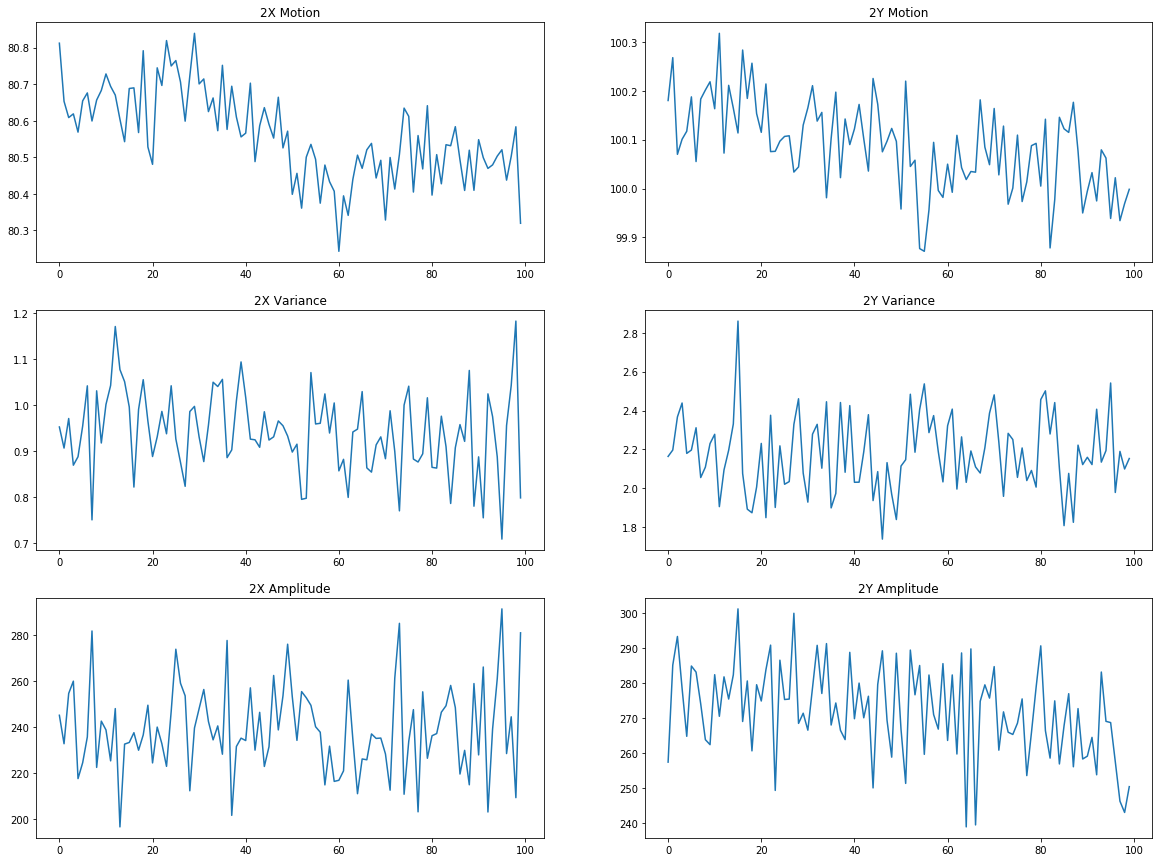

In [27]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))

ax[0,0].plot(mean_2x); ax[0,0].set_title("2X Motion");
ax[0,1].plot(mean_2y); ax[0,1].set_title("2Y Motion")
ax[1,0].plot(sigma_2x); ax[1,0].set_title("2X Variance"); #ax[1,0].set_ylim(-1,4)
ax[1,1].plot(sigma_2y);ax[1,1].set_title("2Y Variance"); #ax[1,1].set_ylim(0,5)
ax[2,0].plot(amp_2x); ax[2,0].set_title("2X Amplitude"); #ax[2,0].set_ylim(0,60)
ax[2,1].plot(amp_2y); ax[2,1].set_title("2Y Amplitude"); #ax[2,1].set_ylim(0,60)

In [28]:
#split array dtc1 into m bins of 'time' (array tc11)
Tmin = min(t_1)
Tmax = max(t_1)

print ('Tmin =', Tmin, ' Tmax = ', Tmax, 'length = ', len(t_1))

Tbin = (Tmax - Tmin)/m
for i in range(0,m):
    start = Tmin + i*Tbin; stop = start + Tbin
    dtbins_1x.append([])
    dtbins_1y.append([])
    print(i, start, stop)
    for j in range(len(x_1)):
        if(start < t_1[j] < stop): 
            dtbins_1x[i].append(x_1[j])
            dtbins_1y[i].append(y_1[j])

Tmin = 2172001.195  Tmax =  164180094.7325 length =  92738
0 2172001.195 3792082.1303749997
1 3792082.1303749997 5412163.065749999
2 5412163.065749999 7032244.001124999
3 7032244.001125 8652324.9365
4 8652324.9365 10272405.871875
5 10272405.871875 11892486.807249999
6 11892486.80725 13512567.742625
7 13512567.742625 15132648.678
8 15132648.678 16752729.613374999
9 16752729.613374999 18372810.54875
10 18372810.54875 19992891.484125
11 19992891.484125 21612972.4195
12 21612972.4195 23233053.354875002
13 23233053.354875 24853134.29025
14 24853134.29025 26473215.225625
15 26473215.225624997 28093296.161
16 28093296.161 29713377.096375
17 29713377.096375 31333458.03175
18 31333458.031749997 32953538.967125
19 32953538.967125 34573619.902499996
20 34573619.902499996 36193700.83787499
21 36193700.837875 37813781.77325
22 37813781.77325 39433862.708624996
23 39433862.708624996 41053943.643999994
24 41053943.644 42674024.579375
25 42674024.579375 44294105.51475
26 44294105.51475 45914186.450124

Ion #1 is a little weird because it disappears in the last 6 seconds of data. Hence the m*.94 in the for loop. 

In [29]:
mean_1x = []; mean_1y = []
sigma_1x = []; sigma_1y = []
amp_1x = []; amp_1y = []
c_1x = []; c_1y = []

xguess_mean_1 = 71
xguess_sigma_1 = 1
xguess_amp_1 = 20000/m
xguess_c_1 = 2500/m
xguess_1  = np.array([xguess_mean_1,xguess_sigma_1,xguess_amp_1,xguess_c_1])

yguess_mean_1 = 99
yguess_sigma_1 = 1
yguess_amp_1 = 35000/m
yguess_c_1 = 5000/m
yguess_1  = np.array([yguess_mean_1,yguess_sigma_1,yguess_amp_1,yguess_c_1])

for i in range(0, m*.94):
    hist_1x, bins_1x = np.histogram(dtbins_1x[i], 9, (66,75)) #, density=True),
    bin_centres_1x = (bins_1x[:-1] + bins_1x[1:])/2
    popt_1x, pcov_1x = scipy.optimize.curve_fit(gaussian, bin_centres_1x, hist_1x, p0=xguess_1, maxfev = 50000)
    mean_1x.append(popt_1x[0]); sigma_1x.append(popt_1x[1]); amp_1x.append(popt_1x[2]); c_1x.append(popt_1x[3])
    hist_fit_1x = gaussian(bin_centres_1x, *popt_1x)
    
    hist_1y, bins_1y = np.histogram(dtbins_1y[i], 11, (95,106)) #, density=True) 
    bin_centres_1y = (bins_1y[:-1] + bins_1y[1:])/2
    popt_1y, pcov_1y = scipy.optimize.curve_fit(gaussian, bin_centres_1y, hist_1y, p0=yguess_1, maxfev = 50000)
    mean_1y.append(popt_1y[0]); sigma_1y.append(popt_1y[1]); amp_1y.append(popt_1y[2]); c_1x.append(popt_1y[3])
    hist_fit_1y = gaussian(bin_centres_1y, *popt_1y)
    
#    plt.figure(figsize=(8, 4))
#    plt.plot(bin_centres_4x, hist_4x, 'ro')
#    plt.plot(bin_centres_4x, hist_fit_4x)
#    plt.plot(bin_centres_4y, hist_4y, 'go')
#    plt.plot(bin_centres_4y, hist_fit_4y)
#    plt.show()

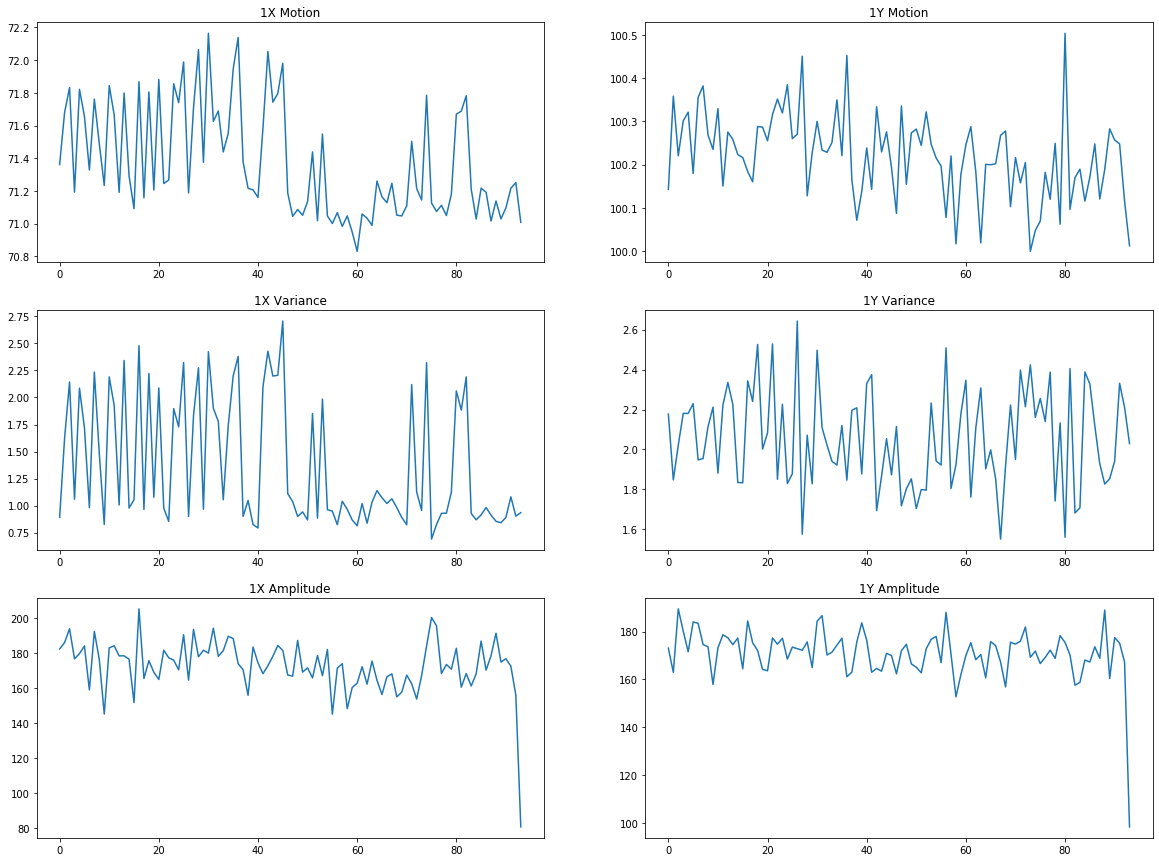

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))

ax[0,0].plot(mean_1x); ax[0,0].set_title("1X Motion"); #ax[0,0].set_ylim(70,75)
ax[0,1].plot(mean_1y); ax[0,1].set_title("1Y Motion")
ax[1,0].plot(sigma_1x); ax[1,0].set_title("1X Variance"); #ax[1,0].set_ylim(-1,4)
ax[1,1].plot(sigma_1y);ax[1,1].set_title("1Y Variance"); #ax[1,1].set_ylim(0,5)
ax[2,0].plot(amp_1x); ax[2,0].set_title("1X Amplitude"); #ax[2,0].set_ylim(0,60)
ax[2,1].plot(amp_1y); ax[2,1].set_title("1Y Amplitude"); #ax[2,1].set_ylim(0,60)

In [58]:
base = np.linspace(0,100,100)
mean_4x_fitc = np.polyfit(base, mean_4x, 1)
mean_4x_fit = np.poly1d(mean_4x_fitc)
mean_3x_fitc = np.polyfit(base, mean_3x, 1)
mean_3x_fit = np.poly1d(mean_3x_fitc)
mean_2x_fitc = np.polyfit(base, mean_2x, 1)
mean_2x_fit = np.poly1d(mean_2x_fitc)

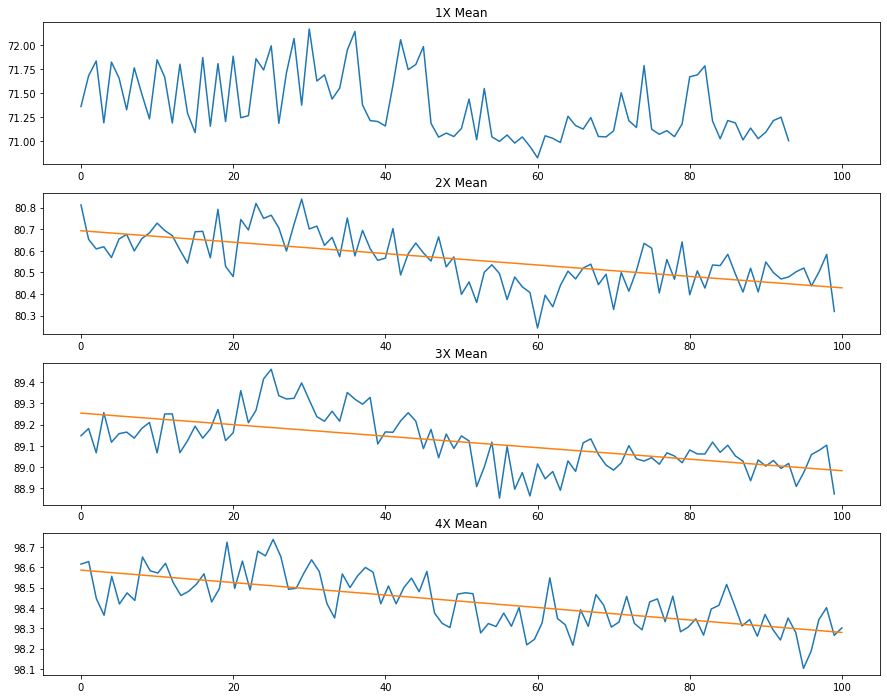

In [59]:
fig, ax = plt.subplots(4, 1, figsize=(15, 12))
ax[0].plot(mean_1x); ax[0].set_title("1X Mean"); ax[0].set_xlim(-5,105); 
ax[1].plot(mean_2x); ax[1].set_title("2X Mean"); ax[1].plot(base, mean_2x_fit(base))
ax[2].plot(mean_3x); ax[2].set_title("3X Mean"); ax[2].plot(base, mean_3x_fit(base))
ax[3].plot(base, mean_4x); ax[3].set_title("4X Mean"); ax[3].plot(base, mean_4x_fit(base))

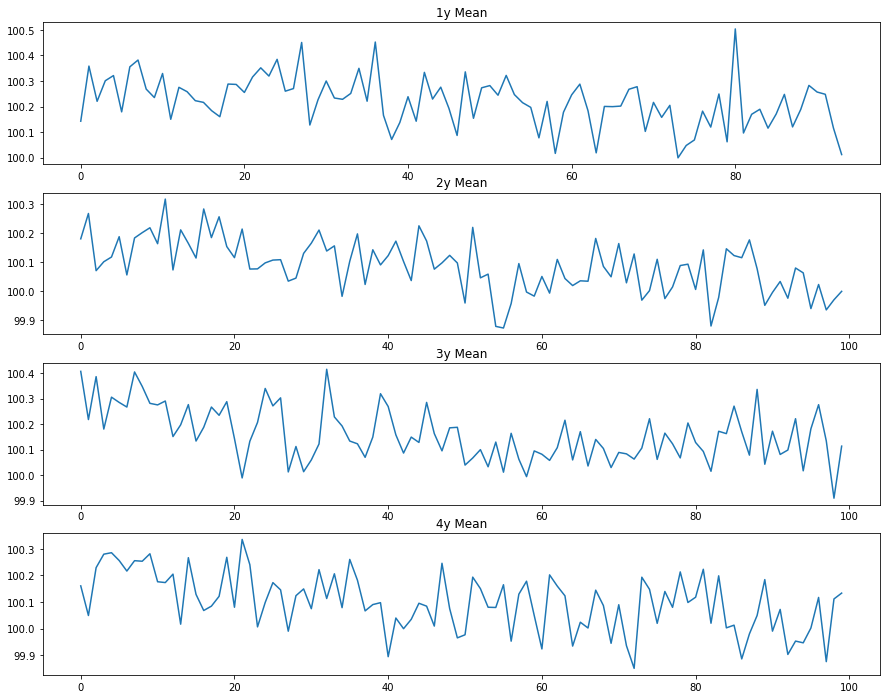

In [32]:
fig, ax = plt.subplots(4, 1, figsize=(15, 12))
ax[0].plot(mean_1y); ax[0].set_title("1y Mean");
ax[1].plot(mean_2y); ax[1].set_title("2y Mean");
ax[2].plot(mean_3y); ax[2].set_title("3y Mean")
ax[3].plot(mean_4y); ax[3].set_title("4y Mean");

In [33]:
# https://datascienceplus.com/understanding-the-covariance-matrix/
variance_string = (
    f" Variances: \n"
    f"Mean x1 = {(pcov1[0])[0]:.3f} \n"
    f"Mean x2 = {(pcov1[1])[1]:.3f} \n"
    f"Mean sigma1 = {(pcov1[2])[2]:.4f} \n"
    f"Mean sigma2 = {(pcov1[3])[3]:.4f} \n"
    f"Mean ampl1 = {(pcov1[4])[4]:.0f} \n"
    f"Mean ampl2 = {(pcov1[5])[5]:.0f} \n"
    f"Mean c = {(pcov1[6])[6]:.0f} \n"
    )
print(variance_string)

NameError: name 'pcov1' is not defined